# Transfer Learning
Author: Nicola Arici (nicola.arici@unibs.it)

Transfer learning is a key technique in deep learning that allows us to leverage the knowledge learned by a model trained on one task and apply it to another, often related, task. Instead of training a model from scratch—which can be computationally expensive and data-hungry—we start with a pretrained model and adapt it to our specific dataset. This approach is especially useful when working with limited data or resources.

In this notebook, we will apply transfer learning using PyTorch. We’ll start with a ResNet50 model pretrained on the large-scale ImageNet dataset and adapt it to classify images from the Flower102 dataset.

**Resources**

- [Torchvision Models](https://docs.pytorch.org/vision/stable/models.html)



First, we’ll explore the available pretrained models and learn how to load and use them in our workflow.

In [1]:
from torchvision.models import resnet50, ResNet50_Weights
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device", device)

weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights).to(device)

preprocess = weights.transforms()
class_names = weights.meta['categories']

Device cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


Then, we’ll test the adapted model using a few new sample images to evaluate its performance.

In [ ]:
from io import BytesIO
from PIL import Image
import requests
import os

TEST_IMAGE = {
    'banana': 'https://cdn.gvmnet.it/admingvm/media/immagininews/fegatostomacoeintestino/banane_benefici.jpeg',
    'space shuttle': 'https://media-cldnry.s-nbcnews.com/image/upload/t_fit-1500w,f_auto,q_auto:best/msnbc/Components/Photos/060519/060519_shuttle_vlg6p.jpg',
    'French horn': 'https://www.normans.co.uk/cdn/shop/articles/french_horn.jpg?v=1663242562',
    'beacon': 'https://aa-images.co.uk/wp-content/uploads/2021/11/157-New-Brighton-Lighthouse-on-the-beach-scaled-1.jpg',
    'tiger': 'https://files.worldwildlife.org/wwfcmsprod/images/Tiger_resting_Bandhavgarh_National_Park_India/hero_small/6aofsvaglm_Medium_WW226365.jpg'
}


batch = None
labels = []
for label, img in TEST_IMAGE.items():
    response = requests.get(img)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    
    #########################################
    pImg = preprocess(img)

    if batch is None:
        batch = pImg.unsqueeze(0)   # (1, 3, 224, 224)
    else:
        batch = torch.cat((batch, pImg.unsqueeze(0)), dim=0) 

    labels.append(label)

######################################
model.eval()
with torch.no_grad():
    preds = model(batch.to(device))
#####################################

correct = 0
for true_label, p in zip(labels, preds):
    pred_label = p.argmax(dim=-1).item()

    if true_label == class_names[pred_label]:
        correct += 1

print(f"Accuracy: {correct}/{len(TEST_IMAGE)} ")

Accuracy: 5/5 


The Flower102 dataset is a well-known benchmark for image classification tasks. It contains 8,189 images of flowers spanning 102 categories, including a wide variety of species commonly found in the United Kingdom. Each class has between 40 and 258 images, providing a moderate challenge due to its fine-grained distinctions and varying lighting conditions, scales, and poses.

This dataset is often used to evaluate transfer learning and fine-tuning techniques, as it is small enough for rapid experimentation yet diverse enough to test a model’s ability to generalize across visually similar classes.

**Resources**:

- [Torchvision FLower102](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.Flowers102.html#torchvision.datasets.Flowers102)


In [ ]:
from torchvision.datasets import Flowers102
import matplotlib.pyplot as plt


train_set = Flowers102(root='data', split='train', download=True, transform=preprocess)
val_set = Flowers102(root='data', split='val', download=True, transform=preprocess)
test_set = Flowers102(root='data', split='test', download=True, transform=preprocess)

100%|██████████| 345M/345M [00:13<00:00, 26.1MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.90MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 7.95MB/s]


Some stats...

In [4]:
print(f"# Trainset: {len(train_set)}")
print(f"# Valset: {len(val_set)}")
print(f"# Testsett: {len(test_set)}")

print("------------------------------------")

print(f"Data shape: {train_set[0][0].shape}")
print(f"# classes: {len(train_set.classes)}")

# Trainset: 1020
# Valset: 1020
# Testsett: 6149
------------------------------------
Data shape: torch.Size([3, 224, 224])
# classes: 102


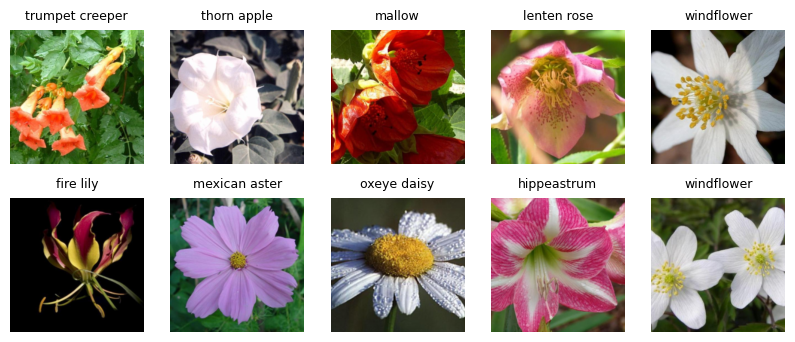

In [30]:
import random

RESNET_MEAN = torch.tensor([0.485, 0.456, 0.406])
RESNET_STD = torch.tensor([0.229, 0.224, 0.225])

def denorm(img):
    img = img.permute(1, 2, 0)  # CxHxW → HxWxC
    img = img * RESNET_STD + RESNET_MEAN       # undo normalization
    img = torch.clamp(img, 0, 1) # keep in [0,1]
    return img.numpy()

random.seed(34566754)
images, labels = zip(*[train_set[i] for i in random.choices(range(len(train_set)), k=10)])

# Create 5x5 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    img = images[i]

    ax.imshow(denorm(img))
    ax.set_title(train_set.classes[labels[i]], fontsize=9, pad=8)
    ax.axis('off')

plt.show()


And let's test ResNet50 over FLower102

In [31]:
from tabulate import tabulate

headers = ["True", "Predicted"]
data = []

for image, label in zip(images, labels):
    model.eval()
    with torch.no_grad():
        preds = model(image.unsqueeze(0).to(device))
        pred_label = preds.argmax(dim=-1).item()

        data.append([ train_set.classes[label], class_names[pred_label]])

print(tabulate(data, headers=headers))

True             Predicted
---------------  -----------------
trumpet creeper  pot
thorn apple      bee
mallow           sulphur butterfly
lenten rose      bee
windflower       daisy
fire lily        artichoke
mexican aster    daisy
oxeye daisy      daisy
hippeastrum      bee
windflower       daisy


Let's create a custom model

In [ ]:
import torch.nn as nn
from tqdm import tqdm

class FlowerModel(nn.Module):
    def __init__(self, device, freeze=True, num_classes=102):
        super(FlowerModel, self).__init__()

        weights = ResNet50_Weights.IMAGENET1K_V2
        self.backbone = resnet50(weights=weights)

        for param in self.backbone.parameters():
            param.requires_grad = False

        self.backbone.fc = nn.Linear(2048, num_classes)

        ########################################################
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.device = device

        self.best_val_loss = float('inf')

    def forward(self, img):
        return self.backbone(img)

    def unfreeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = True


    def train_classifier(self, train_dataloader, val_dataloader, epochs, optimizer, early_stop_ep=5):

        train_loss = []
        train_accs = []

        val_loss = []
        val_accs = []

        ########################################################
        best_model_wts = self.state_dict()
        ep_without_improv = 0

        for ep in range(epochs):
            self.train()
            running_loss = 0.0
            acc = 0
            total = 0

            for it, (images, labels) in enumerate(tqdm(train_dataloader, desc="Train")):

                images = images.to(self.device)
                labels = labels.to(self.device)

                # Forward pass
                logits = self.forward(images)
                loss = self.criterion(logits, labels)

                running_loss += loss.item()

                # Backpropagation
                loss.backward()
                optimizer.step()

                optimizer.zero_grad()

                # Accuracy
                predictions = torch.max(logits, 1).indices

                acc += (predictions.detach().cpu() == labels.detach().cpu()).sum().item()
                total += len(labels)

            epoch_loss = running_loss/len(train_dataloader)
            train_loss.append(epoch_loss)

            epoch_acc = acc*100/total
            train_accs.append(epoch_acc)

            ### VALIDATION
            ep_val_loss, ep_val_acc = self.eval_classifier(val_dataloader)

            val_loss.append(ep_val_loss)
            val_accs.append(ep_val_acc)

            ##############################################################
            if ep_val_loss < self.best_val_loss:
                self.best_val_loss = ep_val_loss
                ep_without_improv = 0
                best_model_wts = self.state_dict()
            else:
                ep_without_improv += 1

            if ep_without_improv == early_stop_ep:
                print(f"\nEarly stoppping afeter {early_stop_ep} epochs...")
                break
            ##############################################################

            print(f"\nEpoch {ep+1}: Val Loss {round(ep_val_loss, 3)} - Val Accuracy {round(ep_val_acc, 2)}%\n")

        #######################################
        self.load_state_dict(best_model_wts)
        return train_loss, train_accs, val_loss, val_accs


    def eval_classifier(self, dataloader):
        self.eval()

        val_loss = 0
        val_accs = 0
        total = 0

        for it, (images, labels) in enumerate(tqdm(dataloader, desc="Val")):

            with torch.no_grad():
                images = images.to(self.device)
                labels = labels.to(self.device)

                # Forward pass
                logits = self.forward(images)

                loss = self.criterion(logits, labels)
                val_loss += loss.item()

                predictions = torch.max(logits, 1).indices
                val_accs += (predictions.detach().cpu() == labels.detach().cpu()).sum().item()
                total += len(labels)

        return val_loss/len(dataloader), val_accs/total*100


    def predict(self, dataloader):
        self.eval()

        predictions = []
        for it, (images, labels) in enumerate(tqdm(dataloader)):

            with torch.no_grad():
                images = images.to(self.device)

                logits = self.forward(images)
                predictions.extend(logits.detach().cpu().numpy().tolist())

        return predictions

In [49]:
from torch.utils.data import DataLoader

BS = 32

###############################################################################
trainloader = DataLoader(train_set, batch_size=BS, shuffle=True, num_workers=2)
valloader = DataLoader(val_set, batch_size=BS, num_workers=2)
testloader = DataLoader(test_set, batch_size=BS, num_workers=2)


flowerModel = FlowerModel(device, freeze=True).to(device)
optimizer = torch.optim.Adam(flowerModel.backbone.parameters(), lr=1e-3)

epochs = 8

train_loss, train_accs, val_loss, val_accs = flowerModel.train_classifier(trainloader, valloader, epochs, optimizer)


Val: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s]



Epoch 1: Val Loss 3.875 - Val Accuracy 57.94%



Val: 100%|██████████| 32/32 [00:06<00:00,  5.05it/s]



Epoch 2: Val Loss 3.222 - Val Accuracy 75.69%



Val: 100%|██████████| 32/32 [00:06<00:00,  5.00it/s]



Epoch 3: Val Loss 2.758 - Val Accuracy 79.41%



Val: 100%|██████████| 32/32 [00:06<00:00,  5.10it/s]



Epoch 4: Val Loss 2.438 - Val Accuracy 82.55%



Val: 100%|██████████| 32/32 [00:06<00:00,  5.08it/s]



Epoch 5: Val Loss 2.188 - Val Accuracy 82.65%



Val: 100%|██████████| 32/32 [00:06<00:00,  4.99it/s]



Epoch 6: Val Loss 2.084 - Val Accuracy 84.8%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]



Epoch 7: Val Loss 1.958 - Val Accuracy 84.12%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


Epoch 8: Val Loss 1.901 - Val Accuracy 84.12%



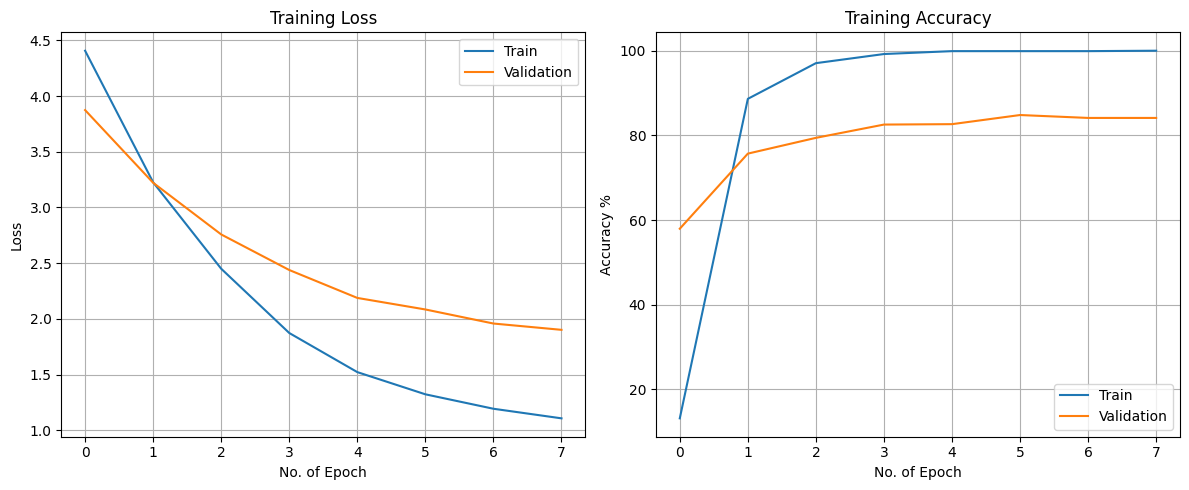

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(range(len(train_loss)), train_loss, label="Train")
axs[0].plot(range(len(val_loss)), val_loss, label="Validation")
axs[0].set_xlabel("No. of Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")
axs[0].grid()
axs[0].legend()

axs[1].plot(range(len(train_accs)), train_accs, label="Train")
axs[1].plot(range(len(val_accs)), val_accs, label="Validation")
axs[1].set_xlabel("No. of Epoch")
axs[1].set_ylabel("Accuracy %")
axs[1].set_title("Training Accuracy")
axs[1].grid()
axs[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [51]:
_, test_acc = flowerModel.eval_classifier(testloader)
print(f"\nAccuracy on Testset: {round(test_acc, 2)}%")

Val: 100%|██████████| 193/193 [00:39<00:00,  4.89it/s]


Accuracy on Testset: 83.27%


Val: 100%|██████████| 32/32 [00:06<00:00,  5.02it/s]



Epoch 1: Val Loss 1.884 - Val Accuracy 84.8%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]



Epoch 2: Val Loss 1.915 - Val Accuracy 84.71%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]



Epoch 3: Val Loss 1.884 - Val Accuracy 84.41%



Val: 100%|██████████| 32/32 [00:06<00:00,  5.11it/s]



Epoch 4: Val Loss 1.895 - Val Accuracy 84.61%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s]



Epoch 5: Val Loss 1.897 - Val Accuracy 85.2%



Val: 100%|██████████| 32/32 [00:06<00:00,  5.10it/s]



Epoch 6: Val Loss 1.879 - Val Accuracy 84.71%



Val: 100%|██████████| 32/32 [00:06<00:00,  4.84it/s]



Epoch 7: Val Loss 1.904 - Val Accuracy 84.61%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]



Epoch 8: Val Loss 1.919 - Val Accuracy 85.2%



Val: 100%|██████████| 32/32 [00:06<00:00,  5.06it/s]



Epoch 9: Val Loss 1.918 - Val Accuracy 84.41%



Val: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]



Epoch 10: Val Loss 1.892 - Val Accuracy 84.61%



Val: 100%|██████████| 32/32 [00:06<00:00,  4.88it/s]



Early stoppping afeter 5 epochs...


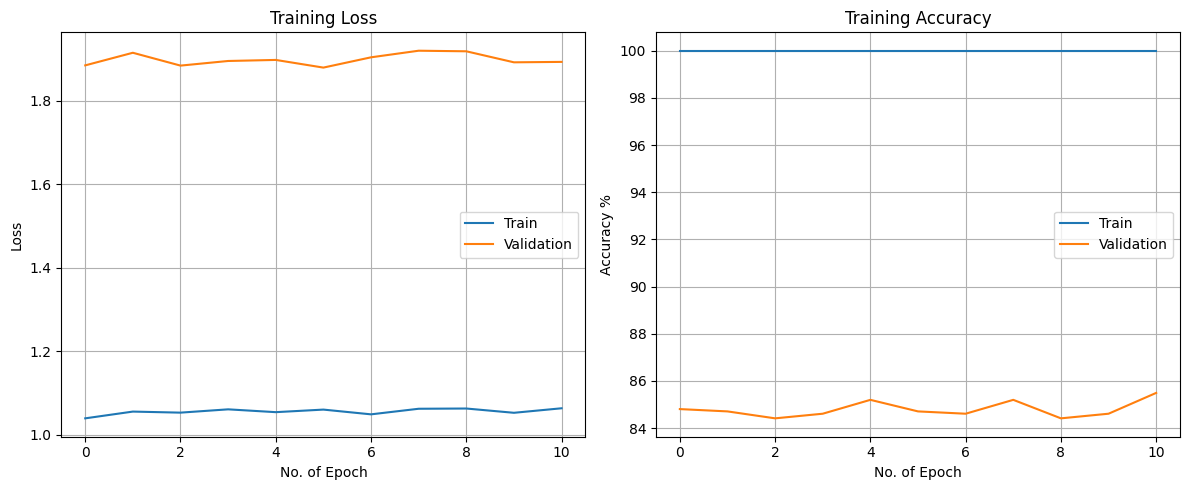

In [52]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

epochs = 25

flowerModel.unfreeze()
train_loss, train_accs, val_loss, val_accs = flowerModel.train_classifier(trainloader, valloader, epochs, optimizer)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(range(len(train_loss)), train_loss, label="Train")
axs[0].plot(range(len(val_loss)), val_loss, label="Validation")
axs[0].set_xlabel("No. of Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")
axs[0].grid()
axs[0].legend()

axs[1].plot(range(len(train_accs)), train_accs, label="Train")
axs[1].plot(range(len(val_accs)), val_accs, label="Validation")
axs[1].set_xlabel("No. of Epoch")
axs[1].set_ylabel("Accuracy %")
axs[1].set_title("Training Accuracy")
axs[1].grid()
axs[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [53]:
_, test_acc = flowerModel.eval_classifier(testloader)
print(f"\nAccuracy on Testset: {round(test_acc, 2)}%")

Val: 100%|██████████| 193/193 [00:39<00:00,  4.92it/s]


Accuracy on Testset: 83.95%
